In [57]:
%reset -f
import plotly.express as px
from graphviz import Digraph
from collections import defaultdict
from itertools import product
import numpy as np

In [58]:
# Вариант
N1 = 32 # вариант лаб2
N2 = N1 + 11
N3 = 111 # по номеру группы
#print(f"{N1 = }\n{N2 = }\n{N3 = }\n")

# Параметры нагрузки
LAM = 0.1
b = 40
P = [0.7, 0.3]

QUEUE_SIZES = [3, 1]
ERLANG_IDX = 1
ERLANG_N = 3

# egormit.
#QUEUE_SIZES = [2, 0]; ERLANG_IDX = 0; ERLANG_N = 2; LAM = 0.6; b = 10; P = [0.5, 0.5]

# Print
N = len(QUEUE_SIZES) # number of devices
MU = 1/b
assert sum(P) == 1
print(f"λ = {LAM}\n{b = }\nμ = {MU}")
for i in range(len(P)):
    print(f'p{i+1} = {P[i]}')


λ = 0.1
b = 40
μ = 0.025
p1 = 0.7
p2 = 0.3


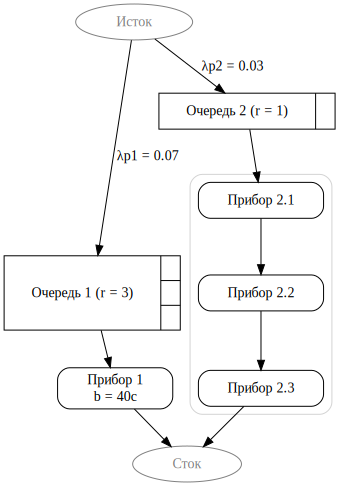

In [59]:
def make_sys_graph(queue_sizes):
    g = Digraph(name=str(queue_sizes))
    g.attr(rankdir = 'TB')
    srcid = 'source'
    sinkid = 'sink'
    for (id, name) in [(srcid, 'Исток'), (sinkid, 'Сток')]:
        g.node(id, name, shape='ellipse', color='gray', fontcolor='gray')
    for i, qs in enumerate(queue_sizes):

        if i == ERLANG_IDX:
            did_in = f'D{i}-0'
            subg = Digraph(name=f'cluster_D{i}')
            subg.attr(color='lightgrey', style='rounded')
            for j in range(ERLANG_N):
                subg.node(f'D{i}-{j}', f'Прибор {i+1}.{j+1}', shape='box', style='rounded')
            for j in range(1, ERLANG_N):
                subg.edge(f'D{i}-{j-1}', f'D{i}-{j}')
            g.subgraph(subg)
            did_out = f'D{i}-{ERLANG_N-1}'
        else:
            did_in = f'D{i}'
            did_out = did_in
            g.node(did_in, f'Прибор {i+1}\nb = {b}с', shape='box', style='rounded')
        
        in_id = did_in
        if qs > 0:
            qid = f'Q{i}'
            g.node(qid, f'Очередь {i+1} (r = {qs})\n|{{{"|"*(qs-1)}}}', shape='record')
            g.edge(qid, did_in)
            in_id = qid        
        g.edge(srcid, in_id, f'λp{i+1} = {LAM * P[i]:.2}')
        g.edge(did_out, sinkid)
    return g

display(make_sys_graph(QUEUE_SIZES))

In [60]:
# State: (N device states, N queue states)

# Add device states
ranges = [range(2)] * N
ranges[ERLANG_IDX] = range(ERLANG_N + 1)

# Add queue states
ranges += [range(q + 1) for q in QUEUE_SIZES]

def state_possible(state):
    assert len(state) == 2 * N
    for i in range(N):
        if state[i] == 0 and state[N+i] != 0:
            return False
    for s in state:
        assert s >= 0
    return True

states = {
    state: {}
    for state in product(*ranges)
    if state_possible(state)
}

print(f'{len(states) = }')

for in_state in states:
    assert len(in_state) == 2 * N
    for idx in range(N):
        out_state_serve = [v for v in in_state]
        out_state_arrive = [v for v in in_state]
        out_state_erlang_proc = [v for v in in_state]
        
        if idx == ERLANG_IDX:
            # Erlang case
            if out_state_erlang_proc[idx] == ERLANG_N:
                # Completion: go idle or take from queue
                if out_state_erlang_proc[idx + N] == 0:
                    out_state_erlang_proc[idx] = 0
                else:
                    out_state_erlang_proc[idx] = 1
                    out_state_erlang_proc[idx + N] -=1
            elif out_state_erlang_proc[idx] > 0:
                # Progress
                out_state_erlang_proc[idx] += 1
        else:
            # Maybe something got served on a non-erlang device... Is device active?
            if out_state_serve[idx] > 0:
                assert idx == ERLANG_IDX or out_state_serve[idx] == 1 # non-erlang case, only 1 active state in device
                # Remove from queue or device
                if out_state_serve[N+idx] > 0:
                    out_state_serve[N+idx] -= 1
                else:
                    out_state_serve[idx] = 0

        # Maybe something arrived... Do we have space in queue (if any) or device?
        if (out_state_arrive[N+idx] < QUEUE_SIZES[idx]) or out_state_arrive[idx] == 0:
            # Insert into device or queue
            if out_state_arrive[idx] == 0:
                assert out_state_arrive[N+idx] == 0 # if device is empty, queue must also be
                out_state_arrive[idx] = 1
            else:
                out_state_arrive[N + idx] += 1

        out_state_serve = tuple(out_state_serve)
        out_state_arrive = tuple(out_state_arrive)
        out_state_erlang_proc = tuple(out_state_erlang_proc)
        assert out_state_arrive in states
        assert out_state_serve in states
        assert out_state_erlang_proc in states

        if out_state_serve != in_state:
            states[in_state][out_state_serve] = (MU, 'green')
        if out_state_arrive != in_state:
            states[in_state][out_state_arrive] = (P[idx] * LAM, 'red')
        if out_state_erlang_proc != in_state:
            states[in_state][out_state_erlang_proc] = (ERLANG_N * MU, 'blue')

len(states) = 35


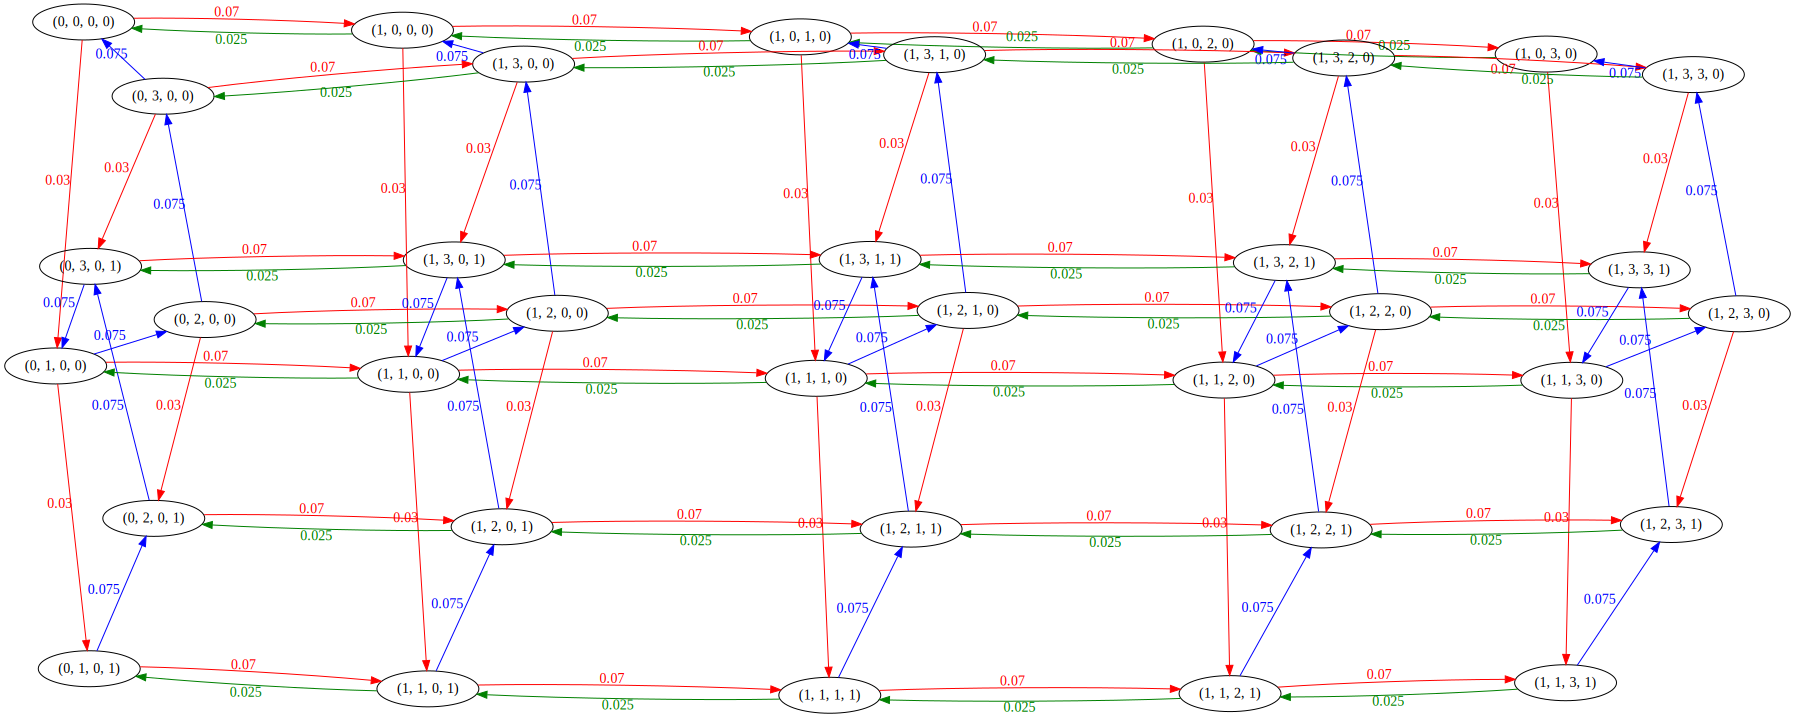

In [61]:
def make_state_graph(states):
    g = Digraph(engine='sfdp')
    g.attr(overlap='scalexy')
    for in_state in states.keys():
        id = str(in_state)
        g.node(id, id)
    for in_state, out_states in states.items():
        for out_state, (rate, color) in out_states.items():
            in_id = str(in_state)
            out_id = str(out_state)
            g.edge(in_id, out_id, f'{rate:.3}', color=color, fontcolor=color)
    return g

display(make_state_graph(states))

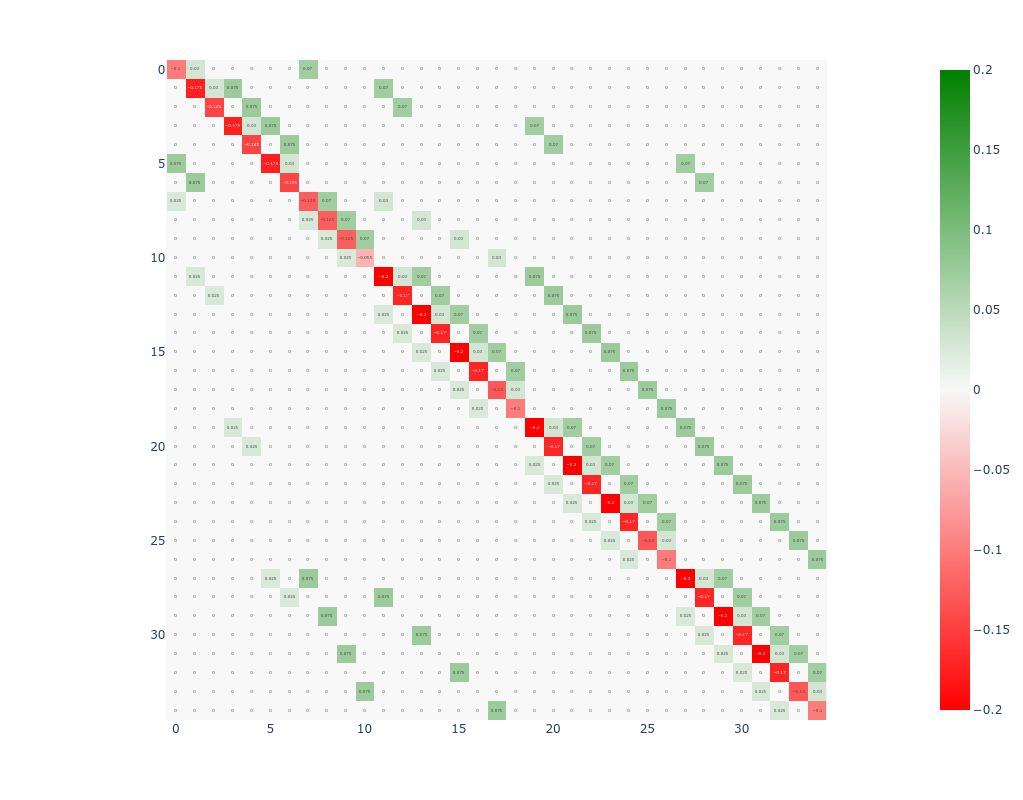

In [62]:
def make_state_indices(states):
    idx = {}
    for i, state in enumerate(states):
        idx[state] = i
        idx[i] = state
    return idx

def make_transition_rate_matrix(states, state_idx):
    N = len(states)
    m = np.zeros((N, N))
    for in_state, out_states in states.items():
        in_idx = state_idx[in_state]
        for out_state, (rate, _color) in out_states.items():
            out_idx = state_idx[out_state]
            m[in_idx, out_idx] = rate
    for i in range(N):
        m[i, i] = -sum(m[i, :])
    return m

state_idx = make_state_indices(states)
transition_rate_matrix = make_transition_rate_matrix(states, state_idx)

fig = px.imshow(
    transition_rate_matrix,
    text_auto = True,
    height = 800,
    color_continuous_scale = [[0, 'red'], [0.5, '#f8f8f8'], [1, 'green']],
    color_continuous_midpoint = 0.0,
)
fig.show()

In [63]:
def solve_states(transition_rate_matrix):
    shape = transition_rate_matrix.shape
    assert len(shape) == 2
    assert shape[0] == shape[1]
    N = shape[0]

    equations = transition_rate_matrix.copy().transpose()
    equations[0, :] = np.ones(N)
    bvector = np.zeros(N)
    bvector[0] = 1
    return np.linalg.solve(equations, bvector)

probs = solve_states(transition_rate_matrix)

for i in range(len(states)):
    print(f'{i}\t{state_idx[i]}\t{probs[i]:.4}')

0	(0, 0, 0, 0)	0.002451
1	(0, 1, 0, 0)	0.001921
2	(0, 1, 0, 1)	0.0007685
3	(0, 2, 0, 0)	0.001372
4	(0, 2, 0, 1)	0.001317
5	(0, 3, 0, 0)	0.0009802
6	(0, 3, 0, 1)	0.00171
7	(1, 0, 0, 0)	0.006862
8	(1, 0, 1, 0)	0.01921
9	(1, 0, 2, 0)	0.0538
10	(1, 0, 3, 0)	0.1506
11	(1, 1, 0, 0)	0.00538
12	(1, 1, 0, 1)	0.002152
13	(1, 1, 1, 0)	0.01506
14	(1, 1, 1, 1)	0.006025
15	(1, 1, 2, 0)	0.04218
16	(1, 1, 2, 1)	0.01687
17	(1, 1, 3, 0)	0.1181
18	(1, 1, 3, 1)	0.04724
19	(1, 2, 0, 0)	0.003843
20	(1, 2, 0, 1)	0.003689
21	(1, 2, 1, 0)	0.01076
22	(1, 2, 1, 1)	0.01033
23	(1, 2, 2, 0)	0.03013
24	(1, 2, 2, 1)	0.02892
25	(1, 2, 3, 0)	0.08435
26	(1, 2, 3, 1)	0.08098
27	(1, 3, 0, 0)	0.002745
28	(1, 3, 0, 1)	0.004787
29	(1, 3, 1, 0)	0.007685
30	(1, 3, 1, 1)	0.0134
31	(1, 3, 2, 0)	0.02152
32	(1, 3, 2, 1)	0.03753
33	(1, 3, 3, 0)	0.06025
34	(1, 3, 3, 1)	0.1051


In [65]:
y = np.array(P) * (LAM / MU) # Нагрузка
pbusy = np.zeros(len(P)) # Загрузка
L = np.zeros(len(P)) # Длина очереди
m = np.zeros(len(P)) # Число заявок
prod = np.zeros(len(P)) # Производительность
loss = np.zeros(len(P)) # Вероятность потери
wtime = np.zeros(len(P)) # Время ожидания
ttime = np.zeros(len(P)) # Время пребывания

for si, prob in enumerate(probs):
  state = state_idx[si]
  for did in range(N):
    if state[did] != 0:
      pbusy[did] += prob
    L[did] += prob * state[N+did]
    if state[did] > 0:
      m[did] += prob * (1 + state[N+did])
    if state[N+did] == QUEUE_SIZES[did] and state[did] > 0:
      loss[did] += prob
prod = LAM * np.array(P) * (1 - loss)
wtime = L / prod
ttime = m / prod

print(f'Нагрузка      {y = }')
print(f'Загрузка      {pbusy = } Σ {sum(pbusy)}')
print(f'Длина очереди {L}, Σ {sum(L)}')
print(f'Число заявок  {m}, Σ {sum(m)}')
print(f'Время ожидания       {wtime}, Σ {sum(L) / sum(prod)}')
print(f'Время пребывания     {ttime}, Σ {sum(m) / sum(prod)}')
print(f'Вероятность потери   {loss}, Σ {sum(loss * P)}')
print(f'Производительность   {prod}, Σ {sum(prod)}')

Нагрузка      y = array([2.8, 1.2])
Загрузка      pbusy = array([0.98948006, 0.76705181]) Σ 1.7565318702926396
Длина очереди [2.48418643 0.36079016], Σ 2.844976590390725
Число заявок  [3.47366649 1.12784197], Σ 4.601508460683364
Время ожидания       [100.42391045  18.8143829 ], Σ 64.78622195261964
Время пребывания     [140.42391045  58.8143829 ], Σ 104.78622195261964
Вероятность потери   [0.64661426 0.36079016], Σ 0.5608670324268402
Производительность   [0.024737  0.0191763], Σ 0.04391329675731598


In [79]:
import pandas as pd
df = {
  'name': [
    'Нагрузка', 
    'Загрузка',
    'Длина очереди',
    'Число заявок',
    'Время ожидания',
    'Время пребывания',
    'Вероятность потери',
    'Производительность',
  ],
  'sys1': [
    4,
    1.6369,
    1.5404,
    3.1773,
    37.6411,
    77.6411,
    0.05908,
    0.0409,
  ],
  'sys2': [
    4,
    1.7565,
    2.8450,
    4.6015,
    64.7862,
    104.7862,
    0.5609,
    0.0439,
  ],
}
df = pd.DataFrame(df)
df = df.transpose()
display(df)
px.histogram(
  df,
  x = 'name',
  y = 0,
)
.show()

,0,1,2,3,4,5,6,7
name,Нагрузка,Загрузка,Длина очереди,Число заявок,Время ожидания,Время пребывания,Вероятность потери,Производительность
sys1,4.0,1.6369,1.5404,3.1773,37.6411,77.6411,0.05908,0.0409
sys2,4.0,1.7565,2.845,4.6015,64.7862,104.7862,0.5609,0.0439


ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of [0, 1, 2, 3, 4, 5, 6, 7] but received: name